# Consurso interno de predicción de Oracle
Alejandro Ozymandias Cepeda Beltran

In [272]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Obtención de datos del stock de Oracle

In [273]:
datos_orcl = pd.read_csv('oracle_stock_prices.csv')
print(datos_orcl.shape)
datos_orcl.head()

(726, 6)


,Date,Open,High,Low,Close,Volume
0,3/01/2023 16:00:00,"82,47","83,84","82,26","83,72",8997534
1,4/01/2023 16:00:00,"84,2","85,17","83,64","84,48",7836238
2,5/01/2023 16:00:00,85,"85,4","83,22","84,31",7643784
3,6/01/2023 16:00:00,"84,74","86,34","83,82","85,66",8641597
4,9/01/2023 16:00:00,"86,84","87,59","86,16","86,42",7519836


In [274]:

close_data = datos_orcl['Close'].values
for i in range(len(close_data)):
    a = close_data[i].replace(',','.')
    close_data[i] = float(a)
close_data = list(close_data.astype('float32'))

# Normalize data using min-max scaling
min_val = min(close_data)
max_val = max(close_data)
normalized_data = [(x - min_val) / (max_val - min_val) for x in close_data]

print(normalized_data)

[np.float32(0.003016091), np.float32(0.006113716), np.float32(0.0054208045), np.float32(0.010923173), np.float32(0.014020767), np.float32(0.014346839), np.float32(0.022906035), np.float32(0.023639683), np.float32(0.025351515), np.float32(0.022906035), np.float32(0.015202756), np.float32(0.0120643955), np.float32(0.017403698), np.float32(0.024414096), np.float32(0.02738942), np.float32(0.027144881), np.float32(0.027919296), np.float32(0.024495598), np.float32(0.017811272), np.float32(0.022335423), np.float32(0.02881598), np.float32(0.026085163), np.float32(0.027063379), np.float32(0.02262073), np.float32(0.019400835), np.float32(0.015121253), np.float32(0.014958217), np.float32(0.016955355), np.float32(0.026248198), np.float32(0.024903173), np.float32(0.021846315), np.float32(0.019319333), np.float32(0.017525967), np.float32(0.013124083), np.float32(0.013613192), np.float32(0.022824533), np.float32(0.023150604), np.float32(0.020297518), np.float32(0.018015075), np.float32(0.013694694), 

### 1. CONFIGURACIÓN Y GENERACIÓN DE DATOS

In [275]:
def crear_secuencias(datos, ventana):
    
    secuencias = []
    labels = []
    L = len(datos)
    for i in range(L - ventana):
        # Tomamos 'ventana' pasos como input
        seq = datos[i : i + ventana]
        # El siguiente paso es lo que queremos predecir
        label = datos[i + ventana]
        secuencias.append(seq)
        labels.append(label)
    return np.array(secuencias), np.array(labels)

# Hiperparámetros
ventana_tiempo = 50  # Cuántos pasos hacia atrás mira la red
test_size = 100

# Preparar dataset
X, y = crear_secuencias(normalized_data, ventana_tiempo)

X.shape


(676, 50)

### 2. PREPARACIÓN DE TENSORES

In [276]:
# Dividir en train/test
train_X = torch.Tensor(X[:-test_size])
train_y = torch.Tensor(y[:-test_size])
test_X = torch.Tensor(X[-test_size:])
test_y = torch.Tensor(y[-test_size:])

# Añadir la dimensión de "Features" (Input_Size) al final
# De (Batch, 50) pasamos a (Batch, 50, 1)
train_X = train_X.unsqueeze(-1)
test_X = test_X.unsqueeze(-1)
# Las etiquetas también necesitan forma correcta para el Loss
train_y = train_y.unsqueeze(-1)
test_y = test_y.unsqueeze(-1)

print(f"Forma de entrada a la LSTM: {train_X.shape}")

Forma de entrada a la LSTM: torch.Size([576, 50, 1])


### 3. Definición del modelo

In [277]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1, num_layers=1):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Definición de la capa LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,     # 1 (solo el valor del seno)
            hidden_size=hidden_dim,   # 50 neuronas en la memoria
            num_layers=num_layers,    # 1 capa apilada
            batch_first=True          # Importante para usar (Batch, Seq, Feat)
        )
        
        # Capa lineal para decodificar la salida de la LSTM a un solo valor
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Features)
        
        # LSTM devuelve: output, (hidden_state, cell_state)
        # output contiene los estados ocultos de TODA la secuencia
        lstm_out, _ = self.lstm(x)
        
        # Solo nos interesa la predicción del ÚLTIMO paso de tiempo
        # Tomamos el último slice temporal: [:, -1, :]
        last_time_step = lstm_out[:, -1, :]
        
        # Pasamos por la lineal para obtener la predicción final
        prediccion = self.linear(last_time_step)
        
        return prediccion
    
# Instanciar modelo, pérdida y optimizador
modelo = LSTMPredictor()
loss_function = nn.MSELoss() # Error Cuadrático Medio (estándar para regresión)
# Optimizador Adam con learning rate de 0.001
optimizer = optim.Adam(modelo.parameters(), lr=0.005)


### 4. Entrenamiento

In [278]:
epochs = 30
grafica = []
print("\nIniciando entrenamiento...")

for i in range(epochs):
    modelo.train()
    
    # 1. Resetear gradientes
    optimizer.zero_grad() 
    
    # 2. Forward pass (Predecir)
    y_pred = modelo(train_X)
    
    # 3. Calcular pérdida
    loss = loss_function(y_pred, train_y)
    
    # 4. Backward pass (Calcular gradientes)
    loss.backward()
    
    # 5. Actualizar pesos
    optimizer.step() 
    
    #if i%5  == 0:
    grafica.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item():.6f}')

print("Entrenamiento finalizado.\n")


Iniciando entrenamiento...
Epoch 0 Loss: 0.021883
Epoch 1 Loss: 0.014204
Epoch 2 Loss: 0.013627
Epoch 3 Loss: 0.014902
Epoch 4 Loss: 0.014324
Epoch 5 Loss: 0.012805
Epoch 6 Loss: 0.011550
Epoch 7 Loss: 0.010990
Epoch 8 Loss: 0.010944
Epoch 9 Loss: 0.010884
Epoch 10 Loss: 0.010354
Epoch 11 Loss: 0.009333
Epoch 12 Loss: 0.008167
Epoch 13 Loss: 0.007315
Epoch 14 Loss: 0.006893
Epoch 15 Loss: 0.006078
Epoch 16 Loss: 0.004196
Epoch 17 Loss: 0.002320
Epoch 18 Loss: 0.002071
Epoch 19 Loss: 0.001522
Epoch 20 Loss: 0.005375
Epoch 21 Loss: 0.001294
Epoch 22 Loss: 0.001695
Epoch 23 Loss: 0.001591
Epoch 24 Loss: 0.001324
Epoch 25 Loss: 0.001537
Epoch 26 Loss: 0.001997
Epoch 27 Loss: 0.002236
Epoch 28 Loss: 0.002096
Epoch 29 Loss: 0.001780
Entrenamiento finalizado.



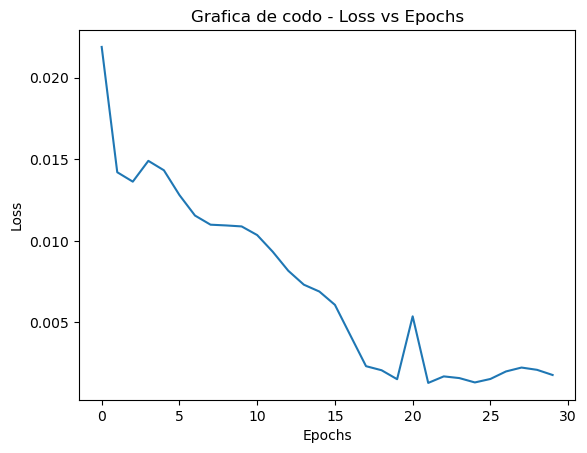

In [279]:
################# Gráfica de codo ####################

# Import required libraries
import matplotlib.pyplot as plt

# Create a simple line plot
plt.plot(grafica)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Grafica de codo - Loss vs Epochs')

# Display the plot
plt.show()

### 5. Evaluación

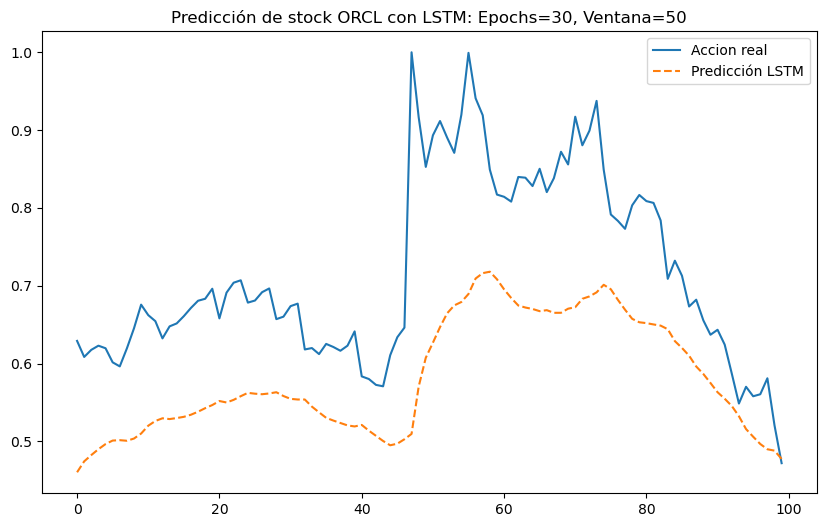

Ejemplo de predicción vs real:
Real: 0.6291 | Predicho: 0.4602


In [280]:
modelo.eval()
with torch.no_grad():
    test_pred = modelo(test_X)

# Convertir a numpy para graficar
real = test_y.numpy()
predicho = test_pred.numpy()

# Descomenta las siguientes líneas si estás en un entorno con pantalla gráfica (Jupyter/Local)
plt.figure(figsize=(10,6))
plt.plot(real, label='Accion real')
plt.plot(predicho, label='Predicción LSTM', linestyle='dashed')
plt.legend()
plt.title(f'Predicción de stock ORCL con LSTM: Epochs={epochs}, Ventana={ventana_tiempo}')
plt.show()

print("Ejemplo de predicción vs real:")
print(f"Real: {real[0][0]:.4f} | Predicho: {predicho[0][0]:.4f}")